In [1]:
'''
(C) 2023 Renata Wong

Electronic structure problem with classical shadows, as presented in https://arxiv.org/abs/2103.07510
This code uses Qiskit as platform. 
'''

import time
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import SparsePauliOp

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

from qiskit.circuit.library import TwoLocal

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

# Estimator primitive is based on the Statevector construct = algebraic simulation
from qiskit.primitives import Estimator 

from modified_derandomization import modified_derandomized_classical_shadow
from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False
import h5py
H5PY_DEFAULT_READONLY=1





driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="6-31g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()

hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

mapper = BravyiKitaevMapper()
bkencoded_hamiltonian = mapper.map(second_q_op)

#print(bkencoded_hamiltonian)

/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []

    for observable in hamiltonian.paulis:
        op_list = []
        for op_index, pauli_op in enumerate(observable):
            pauli_op = str(pauli_op)
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                op_list.append((pauli_op, op_index))
        hamiltonian_observables.append(op_list)
    
    hamiltonian_coefficients = hamiltonian.coeffs.real
    
    system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients



# process the Hamiltonian to obtain properly formatted data
hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = True)
system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients = hamiltonian_data

#print('HAMILTONIAN\n', observables_xyze)

In [11]:
'''
VARIATIONAL ANSATZ
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 5
ansatz = TwoLocal(num_qubits=system_size, reps=reps, rotation_blocks=['ry', 'rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=False)
ansatz.decompose().draw('mpl')






def basis_change_circuit(pauli_op):

    #   Generating circuit with just the basis change operators
    #
    #       pauli_op: n-qubit Pauli operator

    basis_change = QuantumCircuit(ansatz.num_qubits, ansatz.num_qubits)

    for idx, op in enumerate(pauli_op):
        
        if op == 'X':
            basis_change.h(idx)
        if op == 'Y':
            basis_change.h(idx)
            basis_change.p(-np.pi/2, idx)
            
    return basis_change

    
    


def ground_state_energy_from_shadow(operators, params):
    
    backend = QasmSimulator(method='statevector', shots=1)
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    

    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc = qc.compose(basis_change_circuit(pauli_op))                                   # changed
        qc.measure(reversed(range(system_size)), range(system_size))                      # changed
        
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order q0 q1 ... qn-1 after reversal in qc.measure
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values

                output_str = list(count)   
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                shadow.append(snapshot)
    

    expectation_value = 0.0
    for term, weight in zip(observables_xyze, hamiltonian_coefficients):
        
        sum_product, match_count = estimate_exp(shadow, term)
        
        if match_count != 0:
            expectation_value += (weight * sum_product / match_count)

    return expectation_value

In [12]:
'''
Running VQE on the Hamiltonian obtained from PySCFDriver using Statevector simulator (Estimator primitive)
'''

estimator = Estimator()
# If shots = None, it calculates the exact expectation values. Otherwise, it samples from normal distributions 
# with standard errors as standard deviations using normal distribution approximation.
estimator.set_options(shots = None)
vqe_solver = VQE(estimator, ansatz, SLSQP(maxiter=3000))

calc = GroundStateEigensolver(mapper, vqe_solver)
result = calc.solve(problem)
print(result.raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (   0.001832043518416912,
                                                          {}),
                                   'Magnetization': (-7.75015265291612e-05, {}),
                                   'ParticleNumber': (2.0001067026222117, {}),
                                   'XDipole': (0.0, {}),
                                   'YDipole': (0.0, {}),
                                   'ZDipole': (1.3861523139339846, {})},
    'cost_function_evals': 14480,
    'eigenvalue': -1.8499915033930974,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7efbcc25e3a0>,
    'optimal_parameters': {   ParameterVectorElement(θ[70]): -1.565214702637431,
                              ParameterVectorElement(θ[69]): 1.6852924070443394,
                              ParameterVectorElement(θ[68]): 3.2415813749960574,
                              ParameterVectorElement(θ[75]): -4.421152886130877,
            

NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = 1.520034984933042
EXPERIMENT 1: GROUND STATE ENERGY FOUND = 1.521650062536038
EXPERIMENT 2: GROUND STATE ENERGY FOUND = 1.5195817738332182
EXPERIMENT 3: GROUND STATE ENERGY FOUND = 1.5434664885240792
EXPERIMENT 4: GROUND STATE ENERGY FOUND = 1.5147449542558244
EXPERIMENT 5: GROUND STATE ENERGY FOUND = 1.5240803708378983
EXPERIMENT 6: GROUND STATE ENERGY FOUND = 1.5404182003069813
EXPERIMENT 7: GROUND STATE ENERGY FOUND = 1.5246595092240025
EXPERIMENT 8: GROUND STATE ENERGY FOUND = 1.5264463809943487
EXPERIMENT 9: GROUND STATE ENERGY FOUND = 1.5504022202994414
50 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 50}) | 3.378558815762858
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.3835171818796748
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.2586293976172294
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.2600476628322044
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.3878267339042

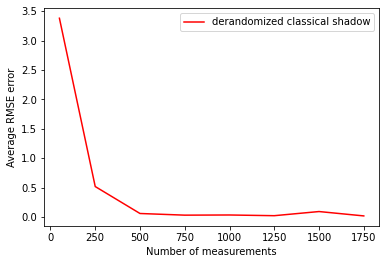

In [13]:
'''
EXPERIMENTS
'''

start_time = time.time()
rmse_errors = []




print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')
measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(observables_xyz, num_operators, 
                                                                      system_size, weight=absolute_coefficients)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        
        expectation_value = ground_state_energy_from_shadow(derandomized_hamiltonian, result.raw_result.optimal_point)
        expectation_values.append(expectation_value)
                
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, expectation_value))


    rmse_derandomised_cs = np.sqrt(np.sum([(expectation_values[i] - result.raw_result.optimal_value)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='derandomized classical shadow')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)




In [6]:
'''
ESTIMATE THE HAMILTONIAN ON OPTIMAL PARAMETERS
'''

qc = ansatz.bind_parameters(result.raw_result.optimal_point)
job_ham = estimator.run(qc, bkencoded_hamiltonian)
result_h = job_ham.result()
print(f">>> Expectation value of the Hamiltonian: {result_h.values[0]}")

expectation_values = []
for index, term in enumerate(bkencoded_hamiltonian.paulis):
    job = estimator.run(qc, term) 
    #print(f">>> Job ID: {job.job_id()}")
    #print(f">>> Job Status: {job.status()}")
    result2 = job.result()
    #print(f">>> {result2}")
    expval = result2.values[0]
    expectation_values.append(expval)
    print("  > Expectation value of {} with coeff {}: {}".format(term, bkencoded_hamiltonian.coeffs.real[index], expval))

total_expval = 0.0
for index, expval in enumerate(expectation_values):
    total_expval += expval * bkencoded_hamiltonian.coeffs.real[index]

print('>>> Total expectation value from summing up expectation values of all terms', total_expval)

>>> Expectation value of the Hamiltonian: -1.4645426565079274
  > Expectation value of IIIIIIII with coeff 1.5280210592332661: 1.0000000000000004
  > Expectation value of IIIIIIIZ with coeff -0.2722152573510048: -0.9999999134155249
  > Expectation value of IIIIIYYX with coeff 0.08812294324841655: 2.168715406098908e-09
  > Expectation value of IIIIIXYY with coeff -0.08812294324841655: 2.2854115674129372e-09
  > Expectation value of IIIIIIZZ with coeff -0.40516889844632553: -0.9563833981646006
  > Expectation value of IIIIIIZI with coeff 0.08852206158533477: 0.9563834810776024
  > Expectation value of IIIIZIXZ with coeff -0.05206368066441221: -0.29211174332271395
  > Expectation value of IIIIIZXI with coeff 0.05206368066441221: 0.292113300233973
  > Expectation value of IIIIZIXI with coeff 0.016033305580191032: 0.29211176823945173
  > Expectation value of IIIIIZXZ with coeff -0.016033305580191032: -0.2921132752922643
  > Expectation value of IIIIIZII with coeff -0.6893596033215873: 0.999

  > Expectation value of IIIXIYYZ with coeff -0.004950549216887833: 3.903604902270324e-07
  > Expectation value of IIZXIXXI with coeff 0.004950549216887833: -8.990704031911604e-08
  > Expectation value of IIIXIXXI with coeff -0.004950549216887833: -8.990723012159159e-08
  > Expectation value of IYYXIIZZ with coeff -0.01240545173820547: -4.992670910734094e-07
  > Expectation value of IXYYIIZZ with coeff 0.01240545173820547: -8.400641693247146e-07
  > Expectation value of IYYXZIXZ with coeff -0.018251453851250748: -3.273260921350929e-07
  > Expectation value of IXYYZIXZ with coeff 0.018251453851250748: -3.905966054049836e-07
  > Expectation value of IYYXIZXI with coeff 0.018251453851250748: 3.3308117784832006e-07
  > Expectation value of IXYYIZXI with coeff -0.018251453851250748: 3.89562875502574e-07
  > Expectation value of ZIXXZYYZ with coeff -0.005280924575648793: -2.4361624155314392e-11
  > Expectation value of IZYYIYYZ with coeff -0.005280924575648793: -4.989244880477237e-11
  > Exp